In [1]:
# # Install all required packages
!pip install -qU \
    langchain==0.3.26 \
    langchain-google-genai==2.1.5 \
    langchain-huggingface==0.3.0 \
    langchain-core==0.3.66 \
    python-dotenv==1.1.1  \
    faiss-cpu==1.11.0 \
    sentence-transformers==4.1.0 \
    langchain-community==0.3.26 \
    torch==2.4.1 \
    torchvision==0.19.1 


In [2]:
from dotenv import load_dotenv

### crete a .env and put your model API key (eg, GOOGLE_API_KEY=xxxxxxxxxxxxxxxxxx)

load_dotenv()

True

### LangChain Expression Language (LCEL)

### LCEL Syntax Basics

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

prompt = ChatPromptTemplate.from_template(
    "Give me a short report about {topic}"
)

model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
output_parser = StrOutputParser()

In [4]:
from langchain.chains import LLMChain

chain = LLMChain(
    prompt=prompt,
    llm=model,
    output_parser=output_parser
)

result = chain.run(topic="Computer Vision")
print(result)

/tmp/ipykernel_8331/3112287091.py:3: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(
/tmp/ipykernel_8331/3112287091.py:9: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run(topic="Computer Vision")


## Computer Vision: Seeing Like a Machine

Computer Vision (CV) is a field of Artificial Intelligence (AI) that empowers computers to "see" and interpret images and videos, much like humans do. It aims to automate tasks that the human visual system can perform, such as object detection, image classification, and scene understanding.

**Key Applications:**

*   **Autonomous Vehicles:** CV is crucial for self-driving cars, enabling them to perceive and navigate their environment by identifying objects like pedestrians, traffic lights, and other vehicles.
*   **Medical Imaging:** CV algorithms analyze medical images (X-rays, MRIs) to detect diseases, tumors, and other anomalies, aiding in diagnosis and treatment planning.
*   **Manufacturing:** CV is used for quality control, defect detection, and robotic guidance in manufacturing processes.
*   **Security and Surveillance:** CV systems can analyze video feeds to detect suspicious activities, identify individuals, and track objects.
*   *

### How the Pipe Operator Works

In [5]:
class Wrapper:
    def __init__(self, value):
        self.value = value

    def __or__(self, func):
        return func(self.value)

def double(x):
    return x * 2

result = Wrapper(5) | double
print(result) 

10


In [6]:
class Runnable:
    def __init__(self, func):
        self.func = func

    def __or__(self, other):
        def chained(x):
            return other(self.func(x))
        return Runnable(chained)

    def __call__(self, x):
        return self.func(x)

In [7]:
def add_five(x):
    return x + 5

def multiply_by_two(x):
    return x * 2

add_five = Runnable(add_five)
multiply_by_two = Runnable(multiply_by_two)

chain = add_five | multiply_by_two
print(chain(3))  # Output: 16

16


# Runnables in LangChain

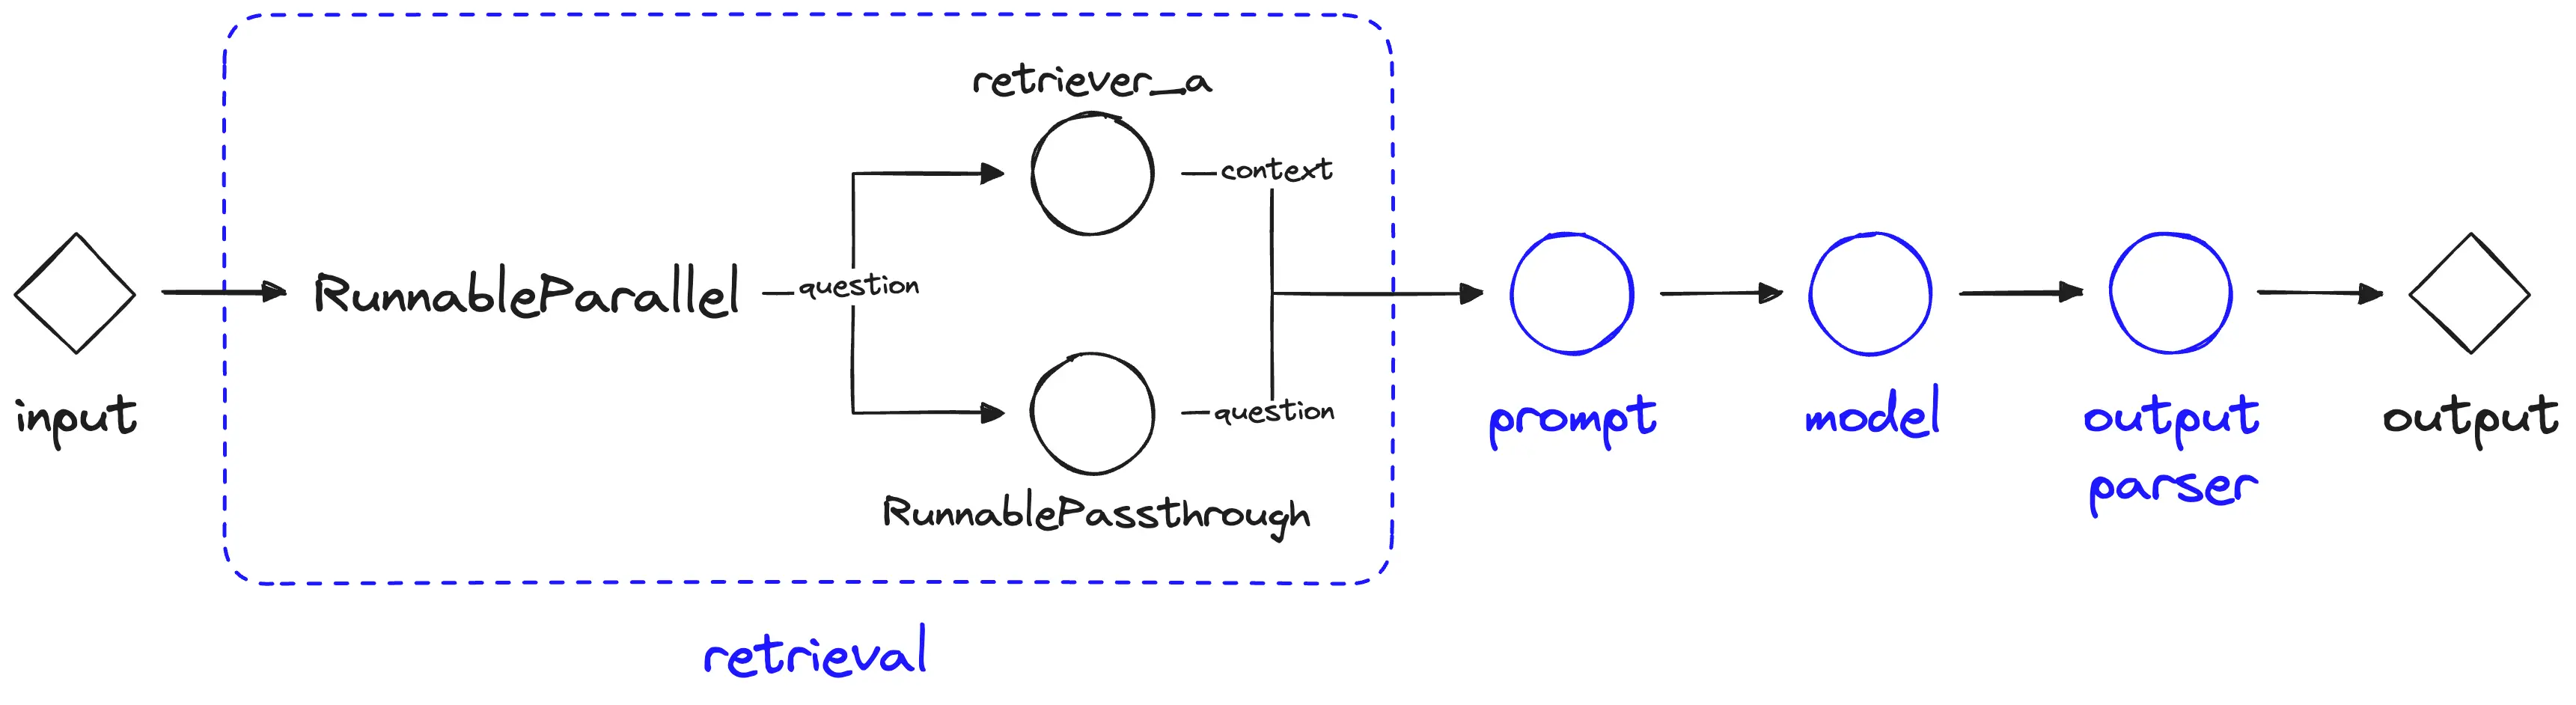

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate

# Initialize embedding model
embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create FAISS vector stores instead of DocArrayInMemorySearch
vecstore_a = FAISS.from_texts(
    ["James' birthday is the 7th December"], 
    embedding=embedding
)
vecstore_b = FAISS.from_texts(
    ["James was born in 1994"], 
    embedding=embedding
)


We're creating two local vector stores here and breaking apart two essential pieces of information between the two vector stores. We'll see why soon, but for now we only need one of these. Let's try passing a question through a RAG pipeline using vecstore_a.



### Case-1 Given half context

In [9]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

# Create retrievers
retriever_a = vecstore_a.as_retriever()
retriever_b = vecstore_b.as_retriever()

# First approach - separate context fields
prompt = ChatPromptTemplate.from_template("""
Answer the question using context:

Context: {context}

Question: {question}

Answer:
""")

retrieval = RunnableParallel(
    {"context": retriever_a, "question": RunnablePassthrough()}
)


In [10]:

# Note: You'll need to define 'model' and 'output_parser' variables
chain = retrieval | prompt | model | output_parser
print(chain.invoke("when was James born?"))


James was born on the 7th of December.


In [11]:
print(chain.invoke("when year James was born?"))

The document doesn't provide the year James was born.


Using this information the chain is close to answering the question but it doesn't have enough information, it is missing the information that we have stored in retriever_b. Fortunately, we can have multiple parallel information streams with the RunnableParallel object.



### Case-2 Given Full context

In [12]:
# Second approach - both context fields
prompt = ChatPromptTemplate.from_template("""
Answer the question using context:

Context A: {context_a}

Context B: {context_b}

Question: {question}

Answer:
""")


retrieval = RunnableParallel({
    "context_a": retriever_a,
    "context_b": retriever_b,
    "question": RunnablePassthrough()
})

In [13]:
# Note: You'll need to define 'model' and 'output_parser' variables
chain = retrieval | prompt | model | output_parser
print(chain.invoke("when was James born?"))


James was born on the 7th of December 1994.


In [14]:
print(chain.invoke("when year James was born?"))

James was born in 1994.


## Runnable Lambdas
The RunnableLambda is a LangChain abstraction that allows us to turn Python functions into pipe-compatible functions, similar to the Runnable class we created near the beginning of this article.

Let's try it out with our earlier add_five and multiply_by_two functions.



In [15]:
from langchain_core.runnables import RunnableLambda

def add_five(x):
    return x + 5

def multiply_by_two(x):
    return x * 2

# wrap the functions with RunnableLambda
add_five = RunnableLambda(add_five)
multiply_by_two = RunnableLambda(multiply_by_two)

In [16]:
chain = add_five | multiply_by_two
chain.invoke(3)

16

As before, we can see the same answer. Naturally, we can feed custom functions into our chains using this approach. Let's try a short chain and see where we might want to insert a custom function:



### RunnableLambda for Custom Logic



In [17]:
prompt_str = "Tell me an short fact about {topic}"
prompt = ChatPromptTemplate.from_template(prompt_str)

chain = prompt | model | output_parser
chain.invoke({"topic": "Artificial Intelligence"})

"One of the earliest demonstrations of AI was a checkers-playing program developed by Christopher Strachey in 1951, showcasing AI's potential for strategic thinking."

In [18]:
# Example 1: Format facts as bullet points
def format_as_bullet(text):
    return f"• {text.strip()}"

format_bullet = RunnableLambda(format_as_bullet)
chain = prompt | model | output_parser | format_bullet

chain.invoke({"topic": "Artificial Intelligence"})

'• One interesting fact about Artificial Intelligence is that the term "artificial intelligence" was coined in 1956 at the Dartmouth Workshop, a summer research project considered to be the founding event of AI as a field.'

Note: As you can see, using the format_as_bullet function, we are getting the output in bullet format. 

In [19]:
# Example 2: Add word count
def add_word_count(text):
    word_count = len(text.split())
    return f"{text} ({word_count} words)"

add_count = RunnableLambda(add_word_count)
chain = prompt | model | output_parser | add_count
chain.invoke({"topic": "Artificial Intelligence"})

'The term "artificial intelligence" was coined in 1956 at the Dartmouth Workshop, a conference considered the birthplace of AI research. (20 words)'